In [2]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# tools for applying bundle adjustment to a temporal sequence of satellite images
import bundle_adjust.ba_timeseries as ba_timeseries


import glob
from bundle_adjust import data_loader as loader
from bundle_adjust import ba_utils
import datetime
from PIL import Image


# Display and interface settings (just for the notebook interface)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set input dirs and display AOIs

In [24]:
input_dsm_dirs = ['exp_new/AOI1_IGARSS_good/ba_n1/4D/metrics/avg_per_date',
                  'exp_new/AOI2_IGARSS_good/ba_n1/4D/metrics/avg_per_date']


aoi_paths = ['/'.join(p.split('/')[:3]) + '/AOI_adj.pickle' for p in input_dsm_dirs]
from bundle_adjust import geotools
geotools.display_lonlat_geojson_list_over_map([loader.load_pickle(fn) for fn in aoi_paths], zoom_factor=14)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Create RBCT DSMs by merging the output of the 2 BA runs (one per aoi)

In [11]:
def merge_neighbor_dsms(dsm_paths, offset=20, med=10, vmax=None, vmin=None,
                        cmap=None, postprocess=False, show=False):
    
    aoi_paths = ['/'.join(p.split('/')[:3]) + '/AOI_adj.pickle' for p in dsm_paths]
    
    #get global utm_bbox
    utm_bbx = {'xmin': np.inf, 'xmax': 0., 'ymin': np.inf, 'ymax': 0.}
    #utm_bbxs = [loader.read_geotiff_metadata(fn)[0] for fn in dsm_paths]
    from bundle_adjust.geotools import utm_bbox_from_aoi_lonlat
    utm_bbxs =  [utm_bbox_from_aoi_lonlat(loader.load_pickle(fn)) for fn in aoi_paths]
    for x in utm_bbxs:
        utm_bbx['xmin'] = min(utm_bbx['xmin'], x['xmin'])
        utm_bbx['xmax'] = max(utm_bbx['xmax'], x['xmax'])
        utm_bbx['ymin'] = min(utm_bbx['ymin'], x['ymin'])
        utm_bbx['ymax'] = max(utm_bbx['ymax'], x['ymax'])
    
    # init output dsm
    resolution = loader.read_geotiff_metadata(dsm_paths[0])[2]
    height = int(np.floor((utm_bbx['ymax'] - utm_bbx['ymin'])/resolution) + 1)
    width = int(np.floor((utm_bbx['xmax'] - utm_bbx['xmin'])/resolution) + 1)
    out_dsm = np.zeros((height, width), dtype=np.float32)
    out_dsm[:] = np.nan
    offsets = []
    
    for aoi_idx, fn in enumerate(dsm_paths):
        
        row = int( height - (utm_bbxs[aoi_idx]['ymax'] - utm_bbx['ymin'])/resolution )
        col = int( (utm_bbxs[aoi_idx]['xmin'] - utm_bbx['xmin'])/resolution )
        offsets.append((row, col))
        
        dsm = np.array(Image.open(fn))
        bbx, _, _, h, w = loader.read_geotiff_metadata(fn)
        row = int( height - (bbx['ymax'] - utm_bbx['ymin'])/resolution )
        col = int( (bbx['xmin'] - utm_bbx['xmin'])/resolution )
        nan_positions = np.isnan(out_dsm[row:row+h, col:col+w])
        dsm_offset = np.nanpercentile(dsm, 20)

        tmp = out_dsm[row:row+h, col:col+w].shape
        h, w = min(tmp[0], h), min(tmp[1], w)
        if offset is not None:
            out_dsm[row:row+h, col:col+w][nan_positions] = dsm[:h, :w][nan_positions] - dsm_offset + offset
        else:
            out_dsm[row:row+h, col:col+w][nan_positions] = dsm[:h, :w][nan_positions]

    total_mask = np.zeros(out_dsm.shape, dtype=np.float32)
    masks = [ba_utils.get_mask_and_its_polygon(p, resolution)[1] for p in aoi_paths]
    for aoi_idx, (o, m) in enumerate(zip(offsets, masks)):
        h, w = m.shape
        row, col = o[0], o[1]
        total_mask[row:row+h, col:col+w] += m
    total_mask = total_mask > 0

    print('nan percent: {:.2f}'.format(np.sum(np.isnan(out_dsm[total_mask]))/np.sum(total_mask.flatten()) * 100.))
    
    if postprocess:

        total_mask = np.zeros(out_dsm.shape, dtype=np.float32)
        masks = [ba_utils.get_mask_and_its_polygon(p, resolution)[1] for p in aoi_paths]
        for aoi_idx, (o, m) in enumerate(zip(offsets, masks)):
            h, w = m.shape
            row, col = o[0], o[1]
            total_mask[row:row+h, col:col+w] += m
        total_mask = total_mask > 0

        from scipy.ndimage import median_filter, generic_filter
        import timeit
        t0 = timeit.default_timer()
        out_dsm_med = generic_filter(out_dsm.copy(), np.nanmedian, size=med)
        out_dsm_med = urbanDSM_utils.interpolate_image(out_dsm_med, method='cubic')
        #plt.figure(figsize=(20,20))
        #plt.imshow(out_dsm_med)
        #plt.show()
        print('nanmedian took {:.2f} secs'.format(timeit.default_timer()-t0))
    
        #out_dsm_med[~np.isnan(out_dsm)] = out_dsm[~np.isnan(out_dsm)]
        #plt.figure(figsize=(20,20))
        #plt.imshow(out_dsm_med)
        #plt.show()
        
        out_dsm = out_dsm_med.copy()
        out_dsm[~total_mask] = np.nan

    if show:
        if vmin is None:
            vmin = np.nanmin(out_dsm)
        if vmax is None:
            vmax = np.nanmax(out_dsm)
            
        current_vmin = vmin
        current_vmax = vmax
        cb_frac, cb_pad, cb_asp = 0.045, 0, 14
        n_ticks, fontsize = 9, 22
        delta = (current_vmax - current_vmin) / (n_ticks - 1)
        cb_tick_pos = [current_vmin + delta * k for k in range(n_ticks + 1)]
        if cb_tick_pos[-1] > current_vmax:
            cb_tick_pos[-1] = current_vmax
        cb_tick_labels = ['{:.1f}'.format(v) for v in cb_tick_pos]
            
        fig = plt.figure(figsize=(20,20))
        ax = plt.gca()
        aoi_polys = [ba_utils.get_mask_and_its_polygon(p, resolution)[0] for p in aoi_paths]
        for x, o in zip(aoi_polys, offsets):
            coords = np.array(x.exterior.xy)
            coords[0, :] += o[1]
            coords[1, :] += o[0]
            ax.plot(*coords, color='black', lw=2)
        cmap = 'gist_earth' if cmap is None else cmap
        im = plt.imshow(out_dsm, cmap=cmap, vmax=vmax, vmin=vmin)
        cb = fig.colorbar(im, ax=ax, fraction=cb_frac, pad=cb_pad,
                          aspect=cb_asp, ticks=cb_tick_pos)
        cb.ax.set_yticklabels(cb_tick_labels, fontsize=fontsize*2)     
        #ax.axis('off')
        plt.show()

    return out_dsm
    


output_dir = 'RBCT_IGARSS'

ref_dsm_paths = sorted(glob.glob(input_dsm_dirs[0]+'/20200528_*/**/cdsm.tif', recursive=True))
aux_dsm_paths = sorted(glob.glob(input_dsm_dirs[1]+'/20200528_*/**/cdsm.tif', recursive=True))

ref_dsm_paths = sorted(glob.glob(input_dsm_dirs[0]+'/*.tif', recursive=True))
for idx, fn in enumerate(ref_dsm_paths):
    
    in_dsm_paths = [os.path.join(p, os.path.basename(fn)) for p in input_dsm_dirs]
    out_dsm_path = os.path.join(output_dir, os.path.basename(fn))
    merged_dsm = merge_neighbor_dsms(in_dsm_paths, vmin=0, vmax=5, cmap='gray',
                                     show=False, postprocess=False, med=10)
    
    #Image.fromarray(merged_dsm).save(out_dsm_path)
    print('\r done {}/{}'.format(idx+1, len(ref_dsm_paths)), end='\r')
    

print('done')

nan percent: 9.57
nan percent: 24.79
nan percent: 29.94
nan percent: 23.05
nan percent: 23.07
nan percent: 19.14
nan percent: 23.99
nan percent: 24.33
nan percent: 17.47
nan percent: 18.89
nan percent: 17.18
nan percent: 19.41
nan percent: 18.03
nan percent: 21.23
nan percent: 21.50
nan percent: 25.40
nan percent: 24.30
nan percent: 18.22
nan percent: 19.77
nan percent: 25.66
nan percent: 22.09
nan percent: 20.75
nan percent: 20.20
nan percent: 27.18
nan percent: 23.25
nan percent: 18.13
nan percent: 20.37
nan percent: 30.12
nan percent: 26.24
nan percent: 17.84
nan percent: 17.24
nan percent: 21.62
nan percent: 17.37
nan percent: 26.98
nan percent: 18.53
nan percent: 25.57
nan percent: 23.39
nan percent: 21.03
nan percent: 25.36
nan percent: 19.53
nan percent: 23.55
nan percent: 19.10
nan percent: 15.96
nan percent: 19.99
nan percent: 14.30
nan percent: 52.88
nan percent: 28.15
donee 47/47


### Compute volume estimates per DSM

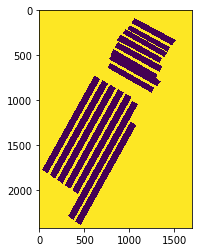

43 valid dsm dates


/home/rogermm14/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/home/rogermm14/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


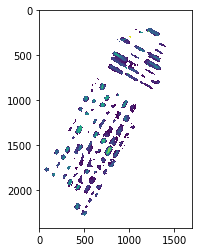

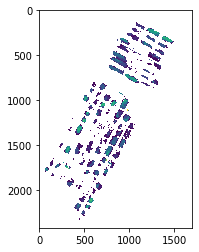

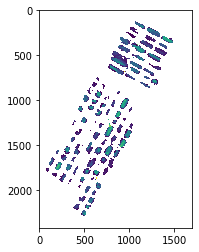

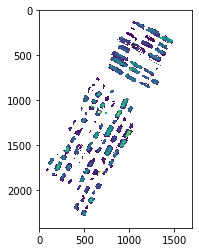

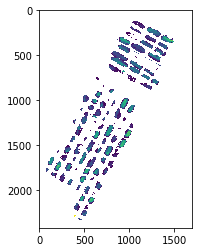

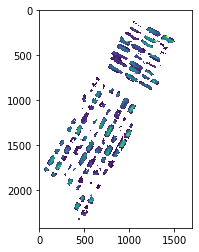

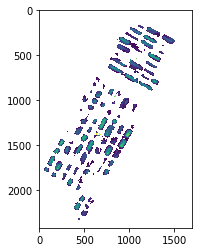

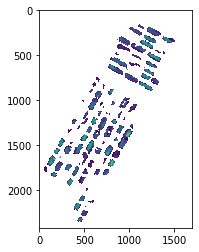

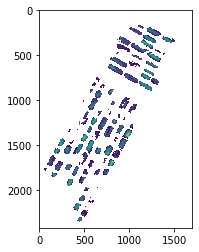

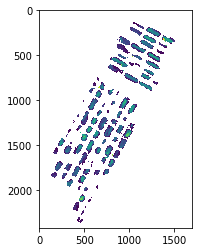

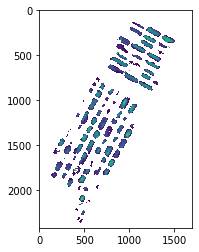

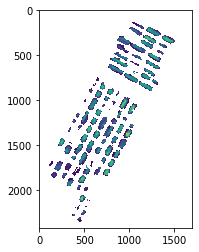

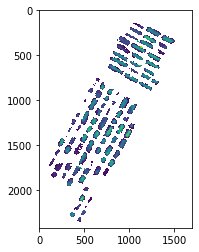

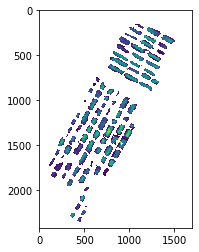

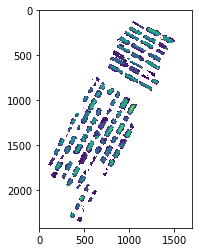

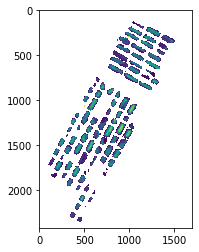

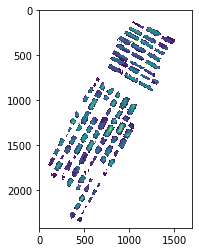

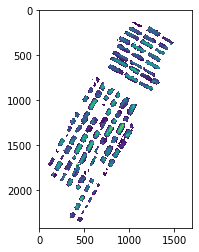

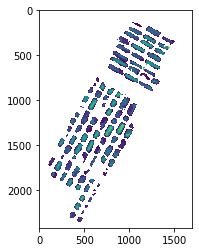

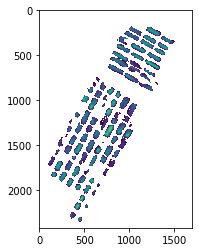

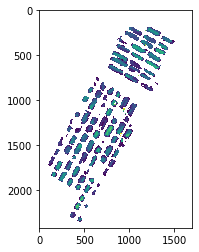

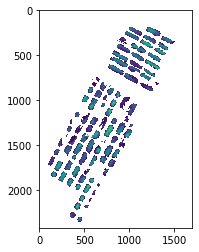

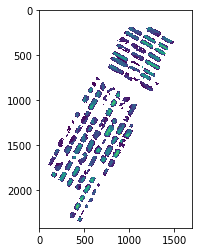

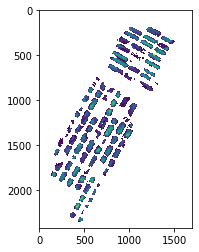

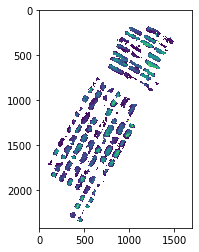

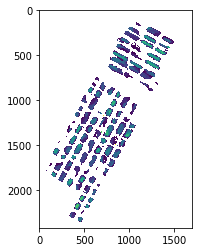

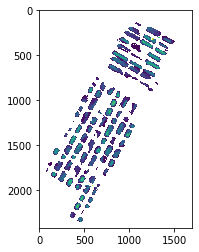

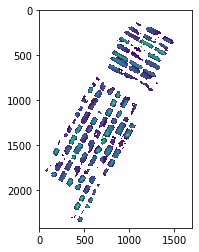

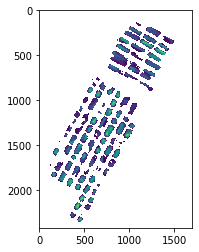

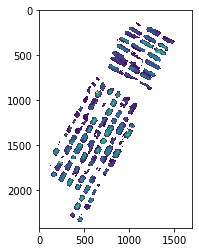

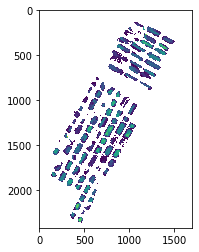

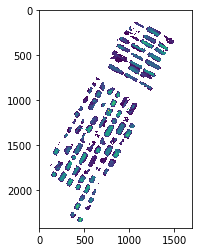

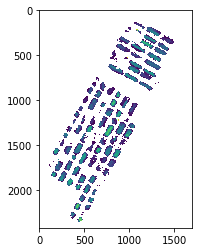

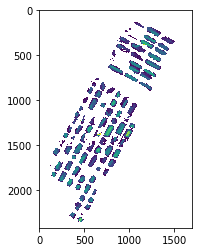

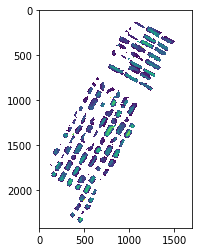

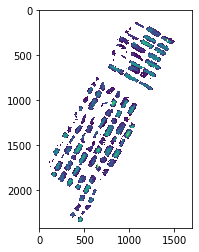

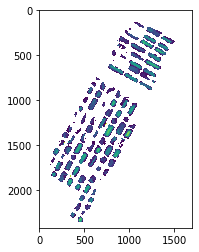

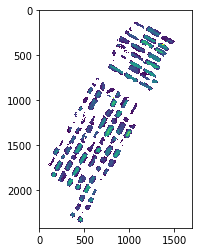

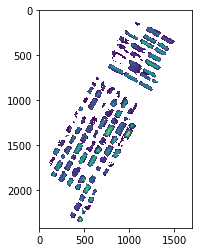

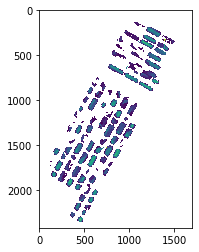

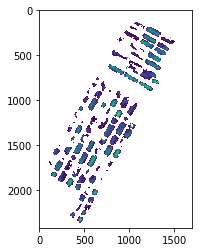

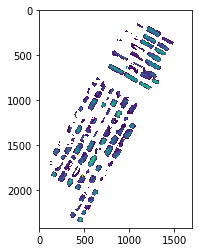

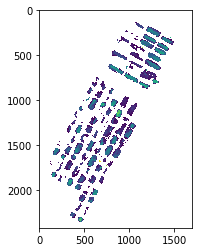

In [12]:
bad_dates = ['2020-02-06', '2020-01-29', '2020-03-04', '2020-05-09']

paths = ['RBCT_IGARSS/n1/merge_post']

bg_masks = [np.array(Image.open('RBCT_IGARSS/manual_mask_n1_v2.png'))<0.1]
bg_masks[0] = bg_masks[0][:, :, 0] if len(bg_masks[0].shape) > 2 else bg_masks[0]
plt.imshow(bg_masks[0])
plt.show()

dsm_paths = sorted(glob.glob(paths[0] + '/*.tif'))  
dsm_ids = [loader.get_id(fn) for fn in dsm_paths]
dsm_labels = ['{}-{}-{}'.format(x[:4], x[4:6], x[6:8]) for x in dsm_ids]
dsm_ids = [i for i, l in zip(dsm_ids, dsm_labels) if l not in bad_dates]
dsm_labels = [d for d in dsm_labels if d not in bad_dates]


print('{} valid dsm dates'.format(len(dsm_labels)))

se = 10
dsm_res = 1.0
dsm_stock = []
bg_values = []
for dsm_id in dsm_ids:
    current_stock = 0.
    ndsms = []
    for aoi_idx, p in enumerate(paths):
        dsm_path = p + '/' + dsm_id + '.tif'
        #dtm_path = p + '/4D/metrics/dtm_per_date_int/' + dsm_id + '.tif'
        dsm = np.array(Image.open(dsm_path))
        #bg = np.array(Image.open(dtm_path))
        #bg = np.zeros(dsm.shape, dtype=np.float32)
        
        bg_pos = 1*bg_masks[aoi_idx] + 1*~np.isnan(dsm) == 2
        bg = np.nanpercentile(dsm[bg_pos], 25)
        #bg = np.nanpercentile(dsm, 30)
        bg_values.append(bg)
        ndsm =  dsm - bg
        ndsm[ndsm < 3] = np.nan
        ndsm[ndsm > 30] = np.nan
        ndsm[bg_pos] = np.nan
        
        
        #ue = morphology.binary_opening(~np.isnan(ndsm), structure=np.ones((se,se)))
        #ndsm[~ue] = np.nan
        ndsms.append(ndsm)
        os.makedirs(p + '/ndsms', exist_ok=True)
        Image.fromarray(ndsm).save(p + '/ndsms/' + os.path.basename(dsm_path))
        os.makedirs(p + '/dsms', exist_ok=True)
        Image.fromarray(dsm).save(p + '/dsms/' + os.path.basename(dsm_path))
        stock_m3 = np.nansum(ndsm)*dsm_res*dsm_res
        current_stock += stock_m3
        
    plt.imshow(ndsms[-1])
    plt.show()
    #ba_utils.display_row_of_dsms(ndsms)
    dsm_stock.append(current_stock)

### Manual attempt to check correlation between on-site measures and volume estimates

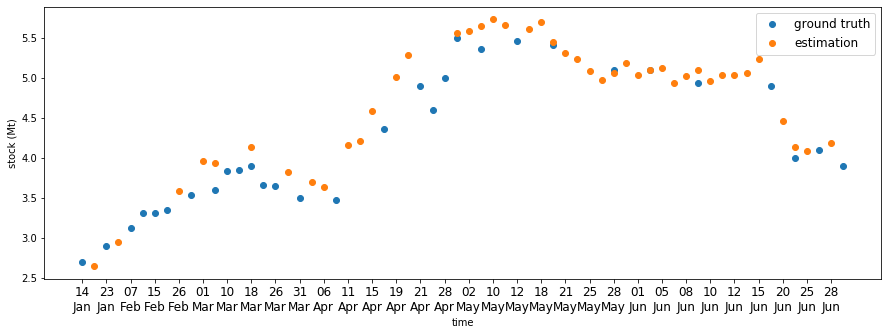

In [14]:
#coal density ranges from approximately 1.1 to about 1.5 megagrams per cubic metre
coal_density = 1.15 #0.85
dsm_stock_Mt = [x * coal_density / 1e6 for x in dsm_stock]

from bundle_adjust import ba_figures

ba_figures.plot_RBCT_evolution_over_time(dsm_stock_Mt, dsm_labels)

### Linear regression to predict Mt from volume estimates

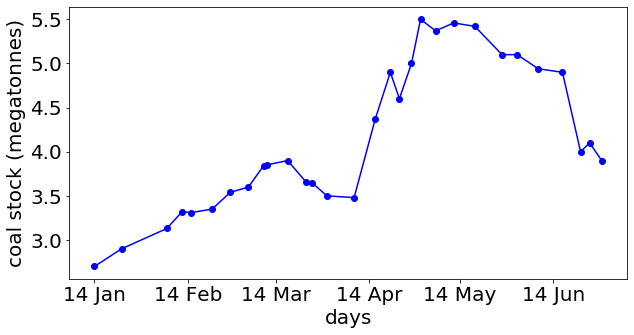

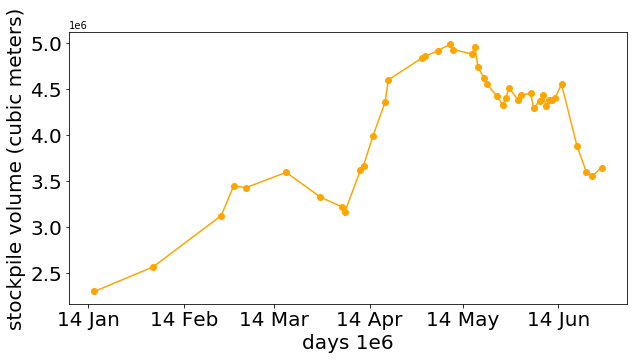

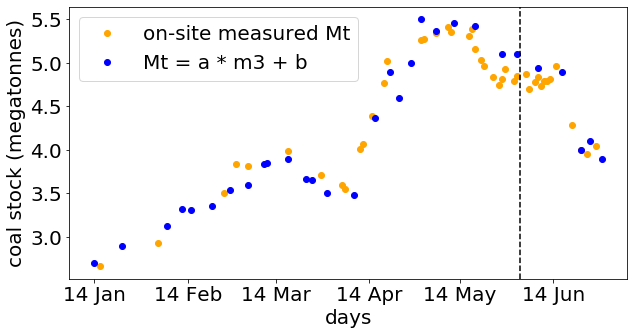

a = 1.0243211639118988e-06, b = 0.3027941292274883


In [17]:
from bundle_adjust import ba_utils
from bundle_adjust import ba_figures

def get_values_ge_zero(x):
    return np.array(x)[np.array(x) >= 0]

def label_to_day(label, start_label):
    start_date = datetime.datetime.strptime(start_label, '%Y-%m-%d')
    date = datetime.datetime.strptime(label, '%Y-%m-%d')
    return (date - start_date).days

import scipy.interpolate
import datetime

start_label = '2020-01-14'
end_label ='2020-07-01'
start_date = datetime.datetime.strptime(start_label, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_label, '%Y-%m-%d')
n_days = (end_date - start_date).days
days = np.arange(n_days)

date_labels_to_plot = ['2020-01-14', '2020-02-14', '2020-03-14', '2020-04-14', '2020-05-14', '2020-06-14']
dates_to_plot = [datetime.datetime.strptime(l, '%Y-%m-%d').strftime("%d %b") for l in date_labels_to_plot]
xticks_pos = [label_to_day(l, start_label) for l in date_labels_to_plot]

interpolation_method = 'linear'
train_percent = 85
train_offset = 0
fs = 20

# (1) fit a function to ground truth days-Mt data
gt_stock, gt_labels = ba_figures.get_GT_RBCT()
gt_days = np.array([label_to_day(l, start_label) for l in gt_labels])
gt_Mt = np.array(gt_stock)[gt_days >= 0]
gt_days = gt_days[gt_days >= 0]
Mt_per_day = scipy.interpolate.interp1d(gt_days, gt_Mt, kind=interpolation_method)
int_gt_days = np.arange(min(gt_days), min(n_days, max(gt_days))+1)
int_gt_Mt = Mt_per_day(int_gt_days)

plt.figure(figsize=(10, 5))
plt.plot(int_gt_days, int_gt_Mt, color='b')
plt.plot(gt_days, gt_Mt, 'o', color='b')
plt.xlabel('days', fontsize=fs)
plt.xticks(xticks_pos, dates_to_plot, fontsize=fs)
plt.ylabel('coal stock (megatonnes)', fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()


# (2) fit a function to estimated days-m3 measures
dsm_days = np.array([label_to_day(l, start_label) for l in dsm_labels])
dsm_volume = np.array(dsm_stock)[dsm_days >= 0]
dsm_days = dsm_days[dsm_days >= 0]
volume_per_day = scipy.interpolate.interp1d(dsm_days, dsm_volume, kind=interpolation_method)
int_dsm_days = np.arange(min(dsm_days), min(n_days, max(dsm_days))+1)
int_dsm_volume = volume_per_day(int_dsm_days)

plt.figure(figsize=(10, 5))
plt.plot(int_dsm_days, int_dsm_volume, color='orange')
plt.plot(dsm_days, dsm_volume, 'o', color='orange')
plt.xlabel('days 1e6', fontsize=fs)
plt.ylabel('stockpile volume (cubic meters)', fontsize=fs)
plt.xticks(xticks_pos, dates_to_plot, fontsize=fs)
plt.yticks(fontsize=fs)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

# linear regression to fit y = Ax + b, where y is Mt and y is the estimated stockpile volume
from scipy.stats import linregress
start_gt = int_dsm_days[0] if int_dsm_days[0] > int_gt_days[0] else 0
start_dsm = int_dsm_days[0] if int_dsm_days[0] < int_gt_days[0] else 0
f = train_percent/100
train_days = int(int_dsm_days[-1]*f) if int_dsm_days[-1] < int_gt_days[-1] else int(int_gt_days[-1]*f)
train_days -= max(start_gt, start_dsm)
start_gt += train_offset
start_dsm += train_offset


a, b, _, _, _ = linregress(int_dsm_volume[start_dsm:start_dsm+train_days+1],
                           int_gt_Mt[start_gt:start_gt+train_days+1])
estimated_Mt = a * dsm_volume + b
int_estimated_Mt = a * int_dsm_volume + b


plt.figure(figsize=(10, 5))
plt.plot(dsm_days, estimated_Mt, 'o', color='orange')
plt.plot(gt_days, gt_Mt, 'o', color='b')
#plt.plot(int_dsm_days, int_estimated_Mt, color='orange')
#plt.plot(int_gt_days, int_gt_Mt, color='b')
#plt.axvline(x=max(start_dsm, start_gt), color='k', linestyle='--')
plt.axvline(x=max(start_dsm, start_gt)+train_days, color='k', linestyle='--')
plt.xlabel('days', fontsize=fs)
plt.ylabel('coal stock (megatonnes)', fontsize=fs)
plt.xticks(xticks_pos, dates_to_plot, fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(['on-site measured Mt', 'Mt = a * m3 + b'], loc='upper left', fontsize=fs)
plt.show()

print('a = {}, b = {}'.format(a, b))

### Plot time differences in day units between consecutive acquisition dates

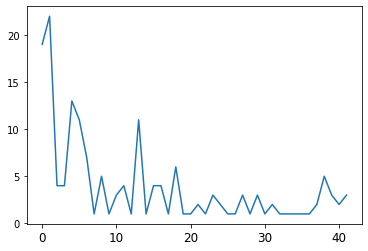

In [25]:
time_diffs = [d - dsm_days[i+1-1] for i, d in enumerate(dsm_days[1:])]
fig = plt.figure()
plt.plot(time_diffs)
plt.show()

### Std over time

running


/home/rogermm14/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


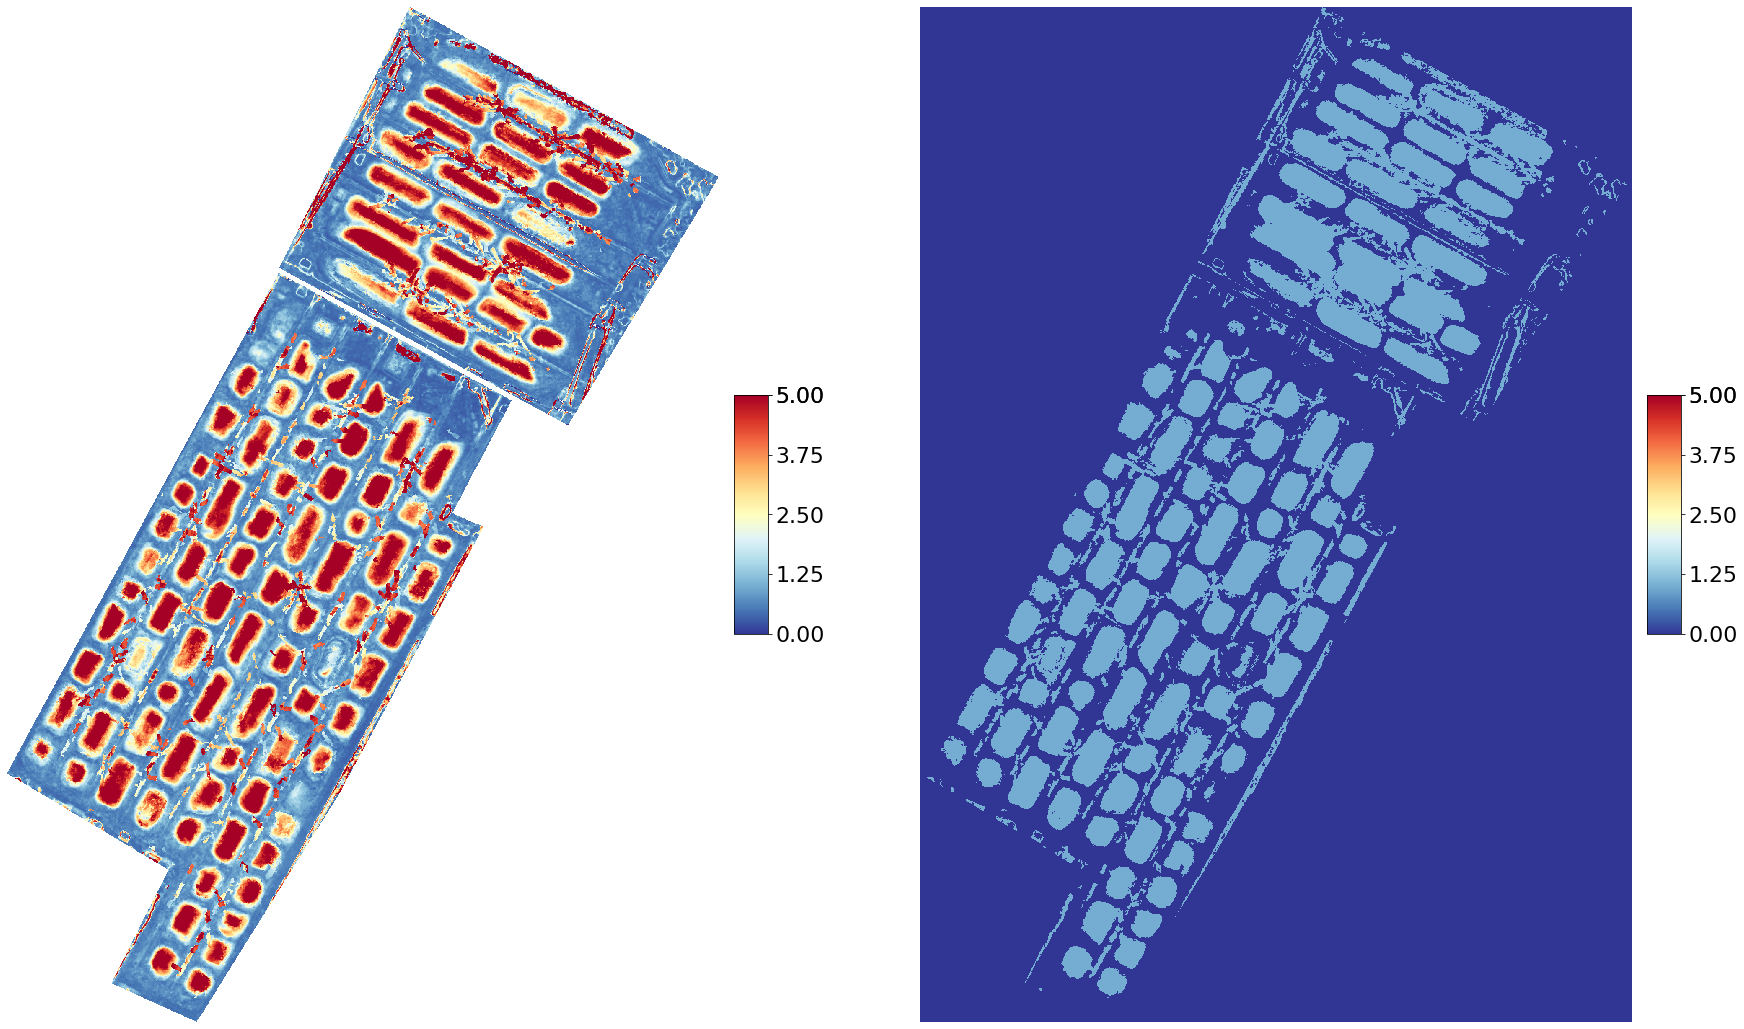

done


In [20]:
print('running')

input_dir = 'RBCT_IGARSS/n1/merge_raw'

bad = [input_dir + '/20200304_075422.tif']
stack = np.dstack([np.array(Image.open(f)) for f in glob.glob(input_dir + '/*.tif') if f not in bad])
std_over_time_init = np.nanstd(stack, axis=2)

#from scipy.ndimage import median_filter, generic_filter
#std_over_time_one = generic_filter(std_over_time_init.copy(), np.nanmedian, size=10)

ba_figures.display_row_of_dsms([std_over_time_init, std_over_time_init>1.5], vmin=0, vmax=5, c='RdYlBu_r')

print('done')

Image.fromarray(std_over_time_init).save('RBCT_IGARSS/n1_std_over_time.tif')
#Image.fromarray(std_over_time_init>1.5).save('manual_mask_n1.png')